# Parte 1: Setup (instalaciones, imports y GPU)

In [45]:
!pip install torch torchvision torchaudio torchmetrics timm -q

# Imports principales
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import timm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

# Verificar GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


Usando dispositivo: cuda


# Parte 2: Datos y Preprocesamiento(CIFAR-10)

In [46]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Transformaciones para entrenamiento / test
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset para entrenamiento y validación (con transformaciones)
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Dataset crudo (sin transformaciones) SOLO para mostrar imágenes originales
raw_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=None)

# Partición de validación (80% train / 20% val)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Clases
classes = train_dataset.classes
print("Clases:", classes)


Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



=== IMÁGENES DE EJEMPLO DEL DATASET ORIGINAL ===


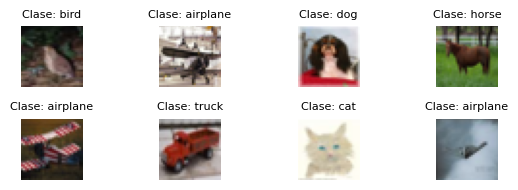

In [47]:
import random

def mostrar_imagenes_ejemplo(dataset, num_samples=8):
    """Muestra imágenes de ejemplo del dataset con clases variadas"""
    fig, axes = plt.subplots(2, 4, figsize=(6, 2))
    axes = axes.ravel()

    # Elegir índices aleatorios sin repetición
    indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]   # ahora se eligen imágenes al azar
        axes[i].imshow(img if not isinstance(img, torch.Tensor) else img.permute(1,2,0))
        axes[i].set_title(f'Clase: {dataset.classes[label]}', fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("\n=== IMÁGENES DE EJEMPLO DEL DATASET ORIGINAL ===")
mostrar_imagenes_ejemplo(raw_dataset)


# Parte 3: Entrenamiento

## Parte 3A: Definición de modelos

In [48]:
def create_resnet50(num_classes=10):
    """Modelo ResNet50 con fine-tuning"""
    model = models.resnet18(pretrained=True)
    # Congelamos las capas iniciales
    for param in model.parameters():
        param.requires_grad = False
    # Reemplazamos la capa final
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


def create_mobilenetv2(num_classes=10):
    """Modelo MobileNetV2 ligero"""
    model = models.mobilenet_v2(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    return model.to(device)


def create_efficientnetb0(num_classes=10):
    """Modelo EfficientNetB0 desde timm"""
    model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=num_classes)
    return model.to(device)


## Parte 3B: Funcion de entrenamiento

In [49]:
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    # Función de pérdida para clasificación multiclase
    criterion = nn.CrossEntropyLoss()

    # Optimizador Adam con tasa de aprendizaje definida
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Historial de métricas para análisis posterior
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    # Bucle de entrenamiento por épocas
    for epoch in range(epochs):
        # ---------------------------
        # Fase de entrenamiento
        # ---------------------------
        model.train()  # activa modo entrenamiento
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            # Enviar tensores a GPU/CPU
            images, labels = images.to(device), labels.to(device)

            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward
            outputs = model(images)

            # Calcular pérdida
            loss = criterion(outputs, labels)

            # Backward (propagación hacia atrás)
            loss.backward()

            # Actualizar pesos
            optimizer.step()

            # Acumular pérdida
            train_loss += loss.item()

            # Calcular predicciones y aciertos
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Exactitud de entrenamiento
        train_acc = 100 * correct / total

        # ---------------------------
        # Fase de validación
        # ---------------------------
        model.eval()  # modo evaluación (sin dropout/batchnorm variable)
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():  # no se calculan gradientes
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Acumular pérdida
                val_loss += loss.item()

                # Calcular predicciones y aciertos
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        # Exactitud de validación
        val_acc = 100 * correct / total

        # Guardar métricas en historial
        history["train_loss"].append(train_loss / len(train_loader))
        history["val_loss"].append(val_loss / len(val_loader))
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # Mostrar resultados de la época
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss/len(train_loader):.4f} "
              f"Val Loss: {val_loss/len(val_loader):.4f} "
              f"Train Acc: {train_acc:.2f}% "
              f"Val Acc: {val_acc:.2f}%")

    return model, history


## Parte 3C: Entrenar ResNet18

In [50]:
resnet50 = create_resnet50(num_classes=10)
resnet50, history_resnet = train_model(resnet50, train_loader, val_loader, epochs=5, lr=1e-3)

# Guardamos historial
torch.save(resnet50.state_dict(), "resnet50_cifar10.pth")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] Train Loss: 0.8604 Val Loss: 0.6481 Train Acc: 72.34% Val Acc: 78.08%
Epoch [2/5] Train Loss: 0.6244 Val Loss: 0.5964 Train Acc: 78.84% Val Acc: 79.82%
Epoch [3/5] Train Loss: 0.5942 Val Loss: 0.5845 Train Acc: 79.55% Val Acc: 79.87%
Epoch [4/5] Train Loss: 0.5758 Val Loss: 0.5714 Train Acc: 80.07% Val Acc: 80.11%
Epoch [5/5] Train Loss: 0.5689 Val Loss: 0.5919 Train Acc: 80.47% Val Acc: 80.02%


## Parte 3D: Entrenar MobileNetV2

In [51]:
mobilenetv2 = create_mobilenetv2(num_classes=10)
mobilenetv2, history_mobilenet = train_model(mobilenetv2, train_loader, val_loader, epochs=5, lr=1e-3)

# Guardamos historial
torch.save(mobilenetv2.state_dict(), "mobilenetv2_cifar10.pth")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] Train Loss: 0.8993 Val Loss: 0.6721 Train Acc: 69.60% Val Acc: 76.88%
Epoch [2/5] Train Loss: 0.7300 Val Loss: 0.6432 Train Acc: 74.21% Val Acc: 77.63%
Epoch [3/5] Train Loss: 0.7024 Val Loss: 0.6390 Train Acc: 75.36% Val Acc: 77.86%
Epoch [4/5] Train Loss: 0.6980 Val Loss: 0.6284 Train Acc: 75.52% Val Acc: 78.08%
Epoch [5/5] Train Loss: 0.6965 Val Loss: 0.6357 Train Acc: 75.72% Val Acc: 77.59%


## Parte 3E: Entrenar EfficientNetB0

In [52]:
efficientnetb0 = create_efficientnetb0(num_classes=10)
efficientnetb0, history_efficientnet = train_model(efficientnetb0, train_loader, val_loader, epochs=5, lr=1e-3)

# Guardamos historial
torch.save(efficientnetb0.state_dict(), "efficientnetb0_cifar10.pth")

Epoch [1/5] Train Loss: 0.4063 Val Loss: 0.2178 Train Acc: 87.20% Val Acc: 92.50%
Epoch [2/5] Train Loss: 0.1816 Val Loss: 0.2175 Train Acc: 93.88% Val Acc: 92.72%
Epoch [3/5] Train Loss: 0.1414 Val Loss: 0.2220 Train Acc: 95.11% Val Acc: 92.65%
Epoch [4/5] Train Loss: 0.1177 Val Loss: 0.2160 Train Acc: 96.02% Val Acc: 93.05%
Epoch [5/5] Train Loss: 0.1031 Val Loss: 0.2433 Train Acc: 96.50% Val Acc: 92.74%


# Parte 4: Evaluación

In [53]:
# Importamos métricas de evaluación de sklearn
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_model(model, test_loader, num_classes=10):

    model.eval()  # Cambiamos el modelo a modo evaluación
    y_true, y_pred, y_prob = [], [], []  # Listas para almacenar etiquetas, predicciones y probabilidades

    with torch.no_grad():  # Desactivamos el cálculo de gradientes (no se entrena aquí)
        for images, labels in test_loader:
            # Enviar datos al dispositivo (GPU/CPU)
            images, labels = images.to(device), labels.to(device)

            # Forward
            outputs = model(images)

            # Aplicar softmax para convertir logits en probabilidades
            probs = nn.Softmax(dim=1)(outputs)

            # Tomar la clase con mayor probabilidad como predicción
            _, predicted = outputs.max(1)

            # Guardar etiquetas reales, predicciones y probabilidades
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    # Convertimos listas a arrays de numpy
    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    # ==========================
    # Cálculo de métricas
    # ==========================
    acc = accuracy_score(y_true, y_pred)  # Exactitud
    f1 = f1_score(y_true, y_pred, average="macro")  # F1 promedio macro
    recall = recall_score(y_true, y_pred, average="macro")  # Recall promedio macro
    try:
        # ROC-AUC para clasificación multiclase (One-vs-Rest)
        roc_auc = roc_auc_score(y_true, y_prob, multi_class="ovr")
    except:
        roc_auc = None  # Si falla, dejamos None (ej. si solo hay una clase en test)

    # Mostrar métricas en consola
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Macro: {f1:.4f}")
    print(f"Recall Macro: {recall:.4f}")
    if roc_auc:
        print(f"ROC-AUC: {roc_auc:.4f}")

    # ==========================
    # Matriz de confusión
    # ==========================
    cm = confusion_matrix(y_true, y_pred)  # Generamos matriz de confusión
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")  # Heatmap sin anotaciones numéricas
    plt.title("Matriz de confusión - ResNet50")
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta real")
    plt.show()

    # Retornamos métricas en un diccionario
    return {"accuracy": acc, "f1": f1, "recall": recall, "roc_auc": roc_auc}


## Parte 4A: Evaluación ResNet50 en Test

Accuracy: 0.7975
F1 Macro: 0.7991
Recall Macro: 0.7975
ROC-AUC: 0.9793


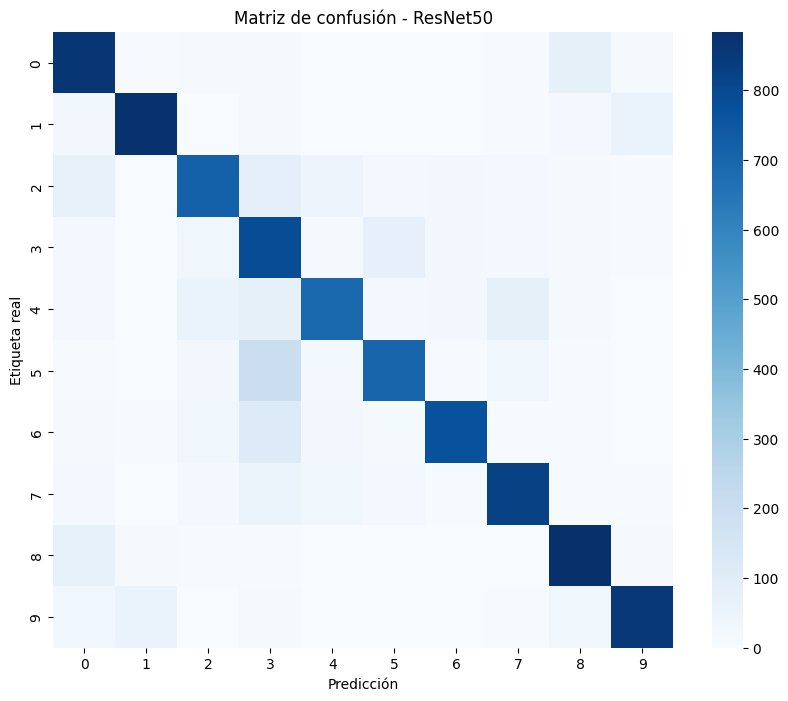

In [54]:
metrics_resnet = evaluate_model(resnet50, test_loader)


## Parte 4B: Evaluación MobileNetV2 en Test

Accuracy: 0.7732
F1 Macro: 0.7744
Recall Macro: 0.7732
ROC-AUC: 0.9752


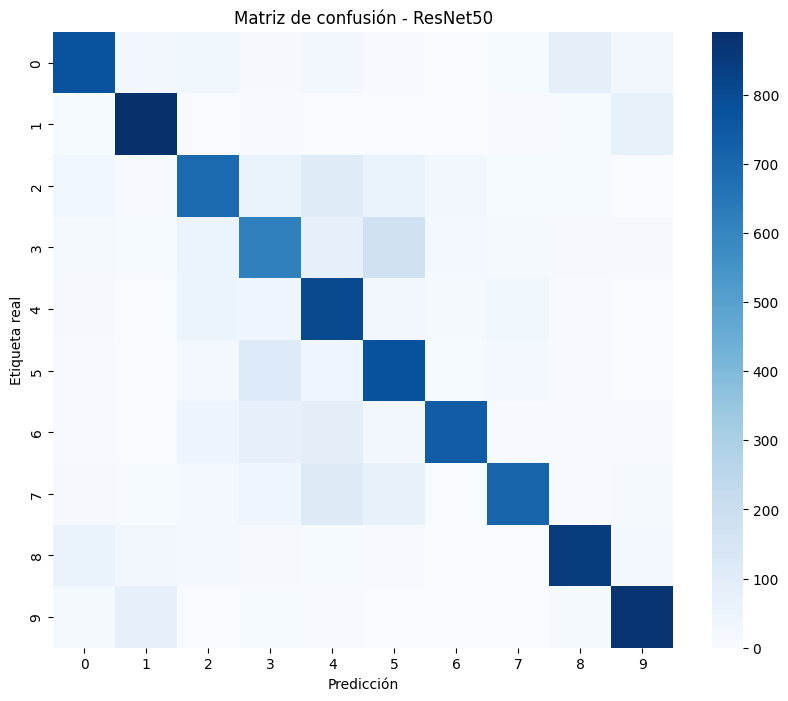

In [55]:
metrics_MobileNetV2 = evaluate_model(mobilenetv2, test_loader)

## Parte 4C: Evaluación EfficientNetB0 en Test

Accuracy: 0.9252
F1 Macro: 0.9251
Recall Macro: 0.9252
ROC-AUC: 0.9963


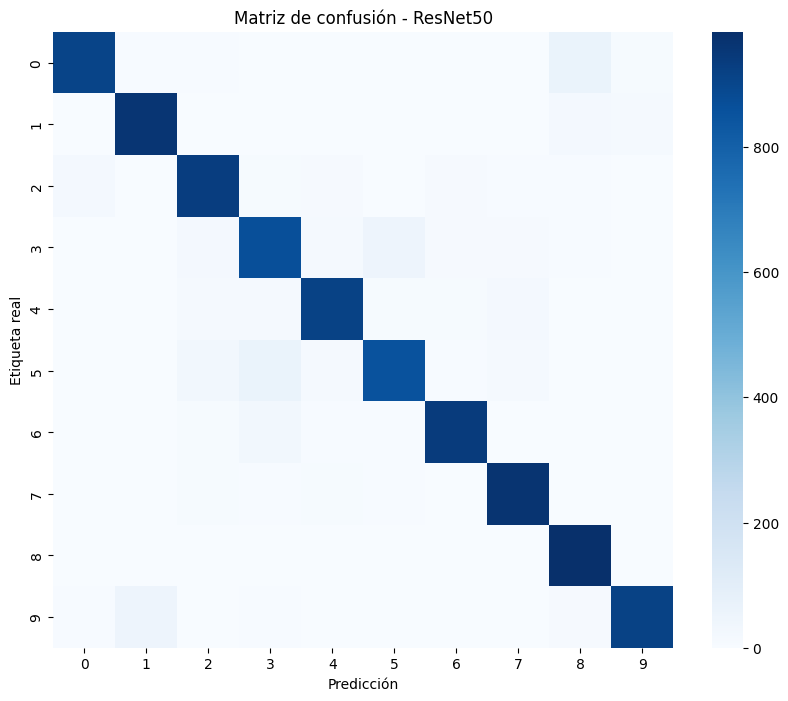

In [56]:
metrics_EfficientNetB0 = evaluate_model(efficientnetb0, test_loader)

## Parte 4D: Evaluación de los tres modelos

In [57]:
# Crear tabla comparativa
import pandas as pd

results_df = pd.DataFrame([
    {"Modelo": "ResNet50", **metrics_resnet},
    {"Modelo": "MobileNetV2", **metrics_MobileNetV2},
    {"Modelo": "EfficientNetB0", **metrics_EfficientNetB0},
])

print("\n📊 Resultados comparativos en Test:")
display(results_df)



📊 Resultados comparativos en Test:


,Modelo,accuracy,f1,recall,roc_auc
0,ResNet50,0.7975,0.799117,0.7975,0.979336
1,MobileNetV2,0.7732,0.774441,0.7732,0.975216
2,EfficientNetB0,0.9252,0.925054,0.9252,0.996297


## Parte 4E: Gráfica comparativa de métricas

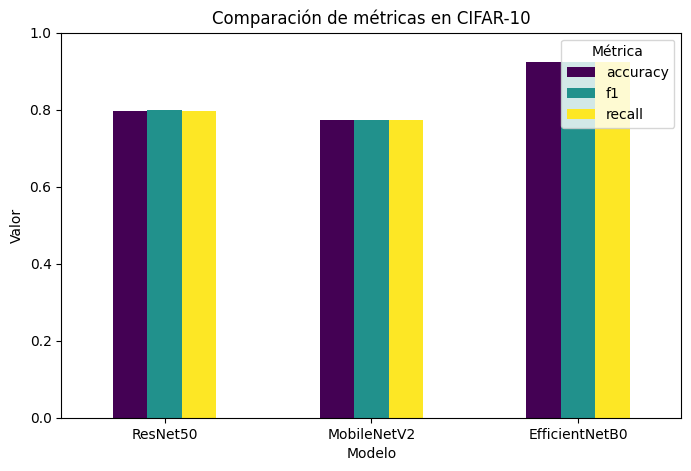

In [58]:
metrics_to_plot = ["accuracy", "f1", "recall"]
results_df.set_index("Modelo")[metrics_to_plot].plot(kind="bar", figsize=(8,5), colormap="viridis")

plt.title("Comparación de métricas en CIFAR-10")
plt.ylabel("Valor")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(title="Métrica")
plt.show()

# Parte 5: Inferencia de imágenes de prueba

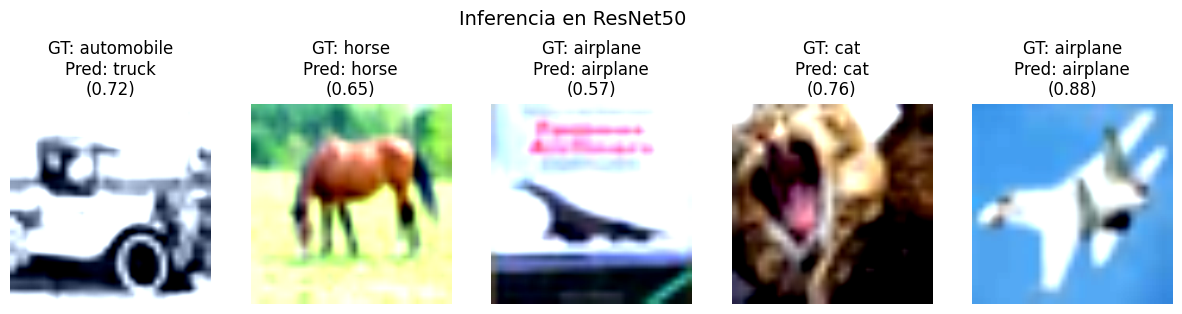

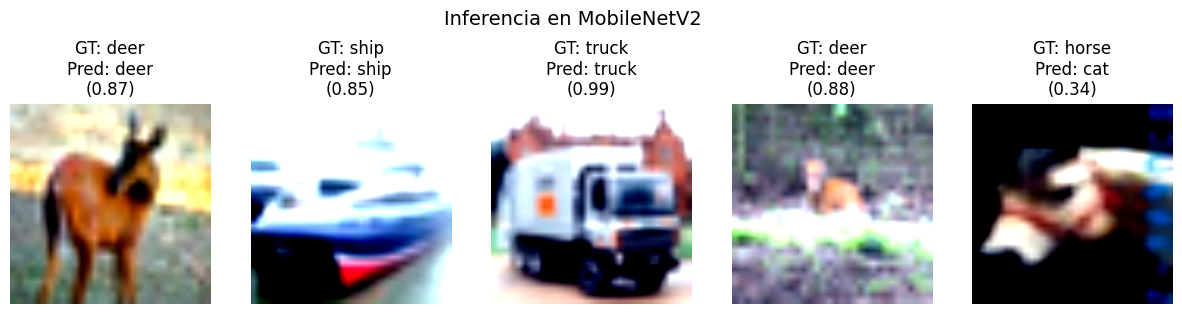

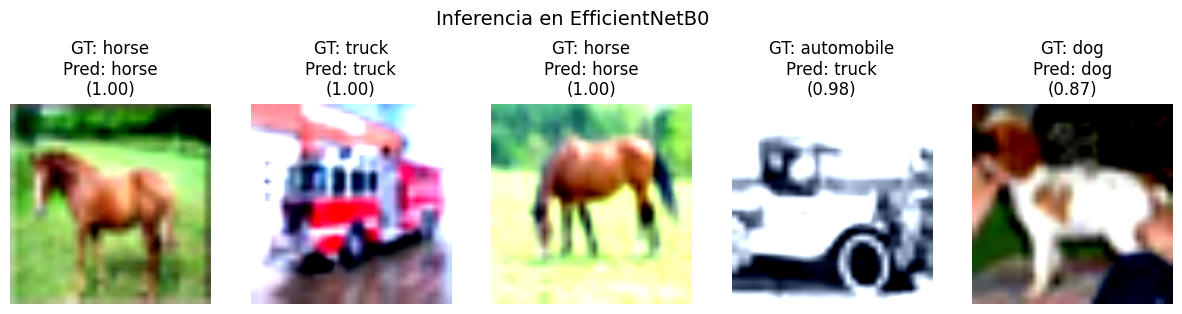

In [59]:
import random

def infer_and_show(model, test_loader, class_names, num_images=5, title="Modelo"):
    model.eval()
    images, labels = next(iter(test_loader))  # Un batch
    images, labels = images.to(device), labels.to(device)

    # Seleccionamos imágenes aleatorias
    idxs = random.sample(range(len(images)), num_images)
    images_sel = images[idxs]
    labels_sel = labels[idxs]

    with torch.no_grad():
        outputs = model(images_sel)
        probs = nn.Softmax(dim=1)(outputs)
        _, preds = torch.max(probs, 1)

    # Mostrar resultados
    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        img = images_sel[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5)  # Desnormalizar

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        true_label = classes[labels_sel[i].item()]
        pred_label = classes[preds[i].item()]
        prob = probs[i][preds[i]].item()
        plt.title(f"GT: {true_label}\nPred: {pred_label}\n({prob:.2f})")

    plt.suptitle(f"Inferencia en {title}", fontsize=14)
    plt.show()

# Inferencia con los tres modelos
infer_and_show(resnet50, test_loader, classes, title="ResNet50")
infer_and_show(mobilenetv2, test_loader, classes, title="MobileNetV2")
infer_and_show(efficientnetb0, test_loader, classes, title="EfficientNetB0")


# Parte 6: Guardado de resultados

## Parte 6A: Crear carpeta de resultados

In [60]:
import os

# Crear carpeta /results si no existe
os.makedirs("results", exist_ok=True)


## Parte 6B: Guardar tabla comparativa en CSV

In [61]:
# Guardar tabla comparativa en CSV
results_df.to_csv("results/comparacion_modelos.csv", index=False)
print("✅ Tabla comparativa guardada en /results/comparacion_modelos.csv")


✅ Tabla comparativa guardada en /results/comparacion_modelos.csv


## Parte 6C: Guardar gráfica comparativa de métricas

In [62]:
# Guardar gráfica de métricas
fig, ax = plt.subplots(figsize=(8,5))
results_df.set_index("Modelo")[["accuracy", "f1", "recall"]].plot(kind="bar", ax=ax, colormap="viridis")

plt.title("Comparación de métricas en CIFAR-10")
plt.ylabel("Valor")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(title="Métrica")
plt.tight_layout()

plt.savefig("results/grafico_metricas.png")
print("✅ Gráfica de métricas guardada en /results/grafico_metricas.png")
plt.close()


✅ Gráfica de métricas guardada en /results/grafico_metricas.png


## Parte 6D: Guardar ejemplos de inferencia

In [63]:
def save_inference_examples(model, test_loader, class_names, title="Modelo", num_images=5, filename="inferencia.png"):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    idxs = random.sample(range(len(images)), num_images)
    images_sel = images[idxs]
    labels_sel = labels[idxs]

    with torch.no_grad():
        outputs = model(images_sel)
        probs = nn.Softmax(dim=1)(outputs)
        _, preds = torch.max(probs, 1)

    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        img = images_sel[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5)

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        true_label = classes[labels_sel[i].item()]
        pred_label = classes[preds[i].item()]
        prob = probs[i][preds[i]].item()
        plt.title(f"GT: {true_label}\nPred: {pred_label}\n({prob:.2f})")

    plt.suptitle(f"Inferencia en {title}", fontsize=14)
    plt.savefig(f"results/{filename}")
    plt.close()
    print(f"✅ Ejemplos de inferencia guardados en results/{filename}")

# Guardar inferencias de los tres modelos
save_inference_examples(resnet50, test_loader, classes, title="ResNet50", filename="inferencia_resnet50.png")
save_inference_examples(mobilenetv2, test_loader, classes, title="MobileNetV2", filename="inferencia_mobilenetv2.png")
save_inference_examples(efficientnetb0, test_loader, classes, title="EfficientNetB0", filename="inferencia_efficientnetb0.png")


✅ Ejemplos de inferencia guardados en results/inferencia_resnet50.png


✅ Ejemplos de inferencia guardados en results/inferencia_mobilenetv2.png


✅ Ejemplos de inferencia guardados en results/inferencia_efficientnetb0.png
